In [1]:
%pylab inline
import hmmlearn, pomegranate, time, seaborn
from hmmlearn.hmm import *
from pomegranate import *
from seqlearn import *

import numpy as np
import pandas as pd
seaborn.set_style('whitegrid')
# import and build
print("Import Success!")

Populating the interactive namespace from numpy and matplotlib
Import Success!


In [2]:
# 1. Error cannot import GHMM
#     Using Linux System

# 2. Error from seqlearn.hmm import *
#    cannot import name 'logsumexp' from 'scipy.misc' (old document)
#    https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.misc.logsumexp.html

# 3. Error cannot imply mlpy
#    conda import fail
#    support Linux 64 only
#    https://anaconda.org/bioconda/mlpy

In [3]:
# scikit -> hmmlearn
# pomegranate -> yahmm

In [4]:
# library version 
# GHMM is not supported in Windows. Will try Linux Ubuntu later
print ("hmmlearn version: ", hmmlearn.__version__)
print ("pomegranate version: ", pomegranate.__version__)

hmmlearn version:  0.2.4
pomegranate version:  0.14.2


In [5]:
# generate Initial transition matrix
def transition_matrix(n_states, topology, randomize=False):
    """HMM initial transition matrix
    Parameters
    ----------
    n_states: int
        The number of states of the HMM. For each state, a mean vector and a covariance matrix are estimated.
    topology: string
        The transition matrix type.
        - full 
        - left-to-right-1
        - left-to-right-2
        - left-to-right-full   upper triangular matrix
    Returns
    -------
    transmat: Array
        Initialized transition martix
    """
    transmat = np.zeros((n_states, n_states))
    if topology.startswith('left-to-right'):
        if topology.endswith('-full'):
            # In the full 'left-to-right' topology each state has a connection to every other state that is located on
            # its right and to itself. The transition matrix is therefore an upper triangular matrix.
            for i in range(n_states):
                transmat[i, i:] = 1.0 / float(n_states - i)
        elif topology.endswith('-1'):
            # Delta = 1, hence self transition + transition to next state is allowed.
            for i in range(n_states):
                if i == n_states-1:
                    transmat[i, i] = 1.0
                else:
                    transmat[i, i] = 0.5
                    transmat[i, i+1] = 0.5
        elif topology.endswith('-2'):
            # Delta = 2, hence self transition + transition to next state + transition to state after next state is allowed.
            for i in range(n_states):
                if i == n_states-1:
                    transmat[i, i] = 1.0
                elif i == n_states-2:
                    transmat[i, i] = 0.5
                    transmat[i, i+1] = 0.5
                else:
                    transmat[i, i] = 1. / 3.
                    transmat[i, i+1] = 1. / 3.
                    transmat[i, i+2] = 1. / 3.
    elif topology == 'full':
        # In the 'full' topology each state is connect with every other state and itself.
        transmat[:, :] = 1.0 / float(n_states)
    else:
        raise ValueError('unknown topology %s' % topology)

    if randomize:
        transmat *= np.random.random(transmat.shape)
        sums = np.sum(transmat, axis=1)
        for row_idx in range(transmat.shape[0]):
            transmat[row_idx] /= sums[row_idx]
    assert np.allclose(np.sum(transmat, axis=1), np.ones(n_states))
    return transmat
transition_matrix(4, "full", True)
transition_matrix(4, "left-to-right-1")
transition_matrix(4, "left-to-right-2")
transition_matrix(4, "left-to-right-full")

array([[0.25      , 0.25      , 0.25      , 0.25      ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.        , 0.        , 0.        , 1.        ]])

In [6]:
# Generate initial start_prob matrix
def start_probabilities(n_states, topology, randomize=False):
    """HMM initial start probabilities matrix
    Parameters
    ----------
    n_states: int
        The number of states of the HMM. For each state, a mean vector and a covariance matrix are estimated.
    topology: string
        The start probabilities matrix type.
        - full 
        - left-to-right
    randomize: decide assign random value to state or just 1
    Returns
    -------
    transmat: Array
        Initialized start prob martix
    """
    pi = np.zeros(n_states)
    if topology.startswith('left-to-right'):
        pi[0] = 1.0
    elif topology == 'full':
        pi[:] = 1.0 / float(n_states)
    else:
        raise ValueError('unknown topology %s' % topology)

    if randomize:
        pi *= np.random.random(pi.shape)
        pi /= np.sum(pi)

    assert np.isclose(np.sum(pi), 1.0)
    return pi

print(start_probabilities(4, "full", True))
print(start_probabilities(4, "left-to-right", True))

[0.27547266 0.38639081 0.12699169 0.21114484]
[1. 0. 0. 0.]


In [7]:
# generate initial mean and covariance parameters
def estimate_normal_distribution_params(n_states, n_features):
    """Estimates parameters (mean and covariance) for a number of states
    Parameters
    ----------
    n_states: int
        The number of states of the HMM. For each state, a mean vector and a covariance matrix are estimated.
    n_features: int
        The number of features of the dataset
    Returns
    -------
    means : array-like, shape=(n_states, n_features)
        The means for all states. Each row represents the means for all n_features.
    covars: array-like, shape=(n_states, n_features, n_features)
        The covars for all states.
    """
    means = np.array([np.random.random(n_features) for _ in range(n_states)])
    covars = []
    for state in range(n_states):
        # Create random semi-definite matrix
        covar = np.random.random((n_features, n_features))
        covars.append(np.dot(covar, covar.T))
    covars = np.array(covars)

    return means, covars

In [8]:
# generate two column timeseries data
# raw data and diff
def generate_timeseries_data(input_csv_file_path):
    datasets=["Earthquakes/Chinatown_TEST_NEW_1.csv", "Earthquakes/Chinatown_TEST_NEW_2.csv"]
    pd_input = pd.read_csv(input_csv_file_path)
    pd_array = pd_input.values
    end_v = pd_array[:, 23]
    pd_array_one = pd_array.flatten()
    hours = pd.date_range('2017-01-01', periods = pd_array_one.shape[0], freq = 'H')
    timeseries = pd.Series(pd_array_one, index = hours)
    # timeSeriesData Format
    diff = np.diff(timeseries)
    X = np.column_stack([timeseries[1:], diff])
    print("X", X)
#     plt.figure()
#     timeseries.plot()
#     plt.title("Time Series Data")
#     plt.show()
#     timeseries.rolling(window = 12, center = False).mean().plot(style = '-g')
#     plt.title("Rolling Mean")
#     plt.show()
#     timeseries.mean()
#     timeseries.max()
#     timeseries.min()
#     timeseries.describe()
    # training data
    return X

In [9]:
def initialize_parameter(obs, n_state, topology, randomize = False):
    transmat_ = transition_matrix(n_state, topology, randomize)
    startprob_ = start_probabilities(n_state, topology, randomize)
    means, covars = estimate_normal_distribution_params(n_state, 2)
    return startprob_, transmat_, means, covars

In [10]:
def hmmlearn_model(start_probs, transmat, means, covars, iteration_time):
    """Return a hmmlearn model."""
    model = GaussianHMM(n_components=transmat.shape[0], covariance_type='full', n_iter=20)
    model.startprob_ = start_probs
    model.transmat_ = transmat
    model.means_ = means
    model._covars_ = covars
    return model

In [11]:
def pomegranate_model(start_probs, transmat, n_state, means, covars):
    """Return a pomegranate model."""
    # (1) by defining both the distributions and the graphical structure manually
    # If you are initializing the parameters manually, you can do so either by passing in a list of distributions 
    # and a transition matrix, or by building the model line-by-line.
    
    # (2) running the from_samples method to learn both the structure and distributions directly from data.
    distributions = [pomegranate.MultivariateGaussianDistribution(means[i], covars[i]) for i in range(n_state)]

    # Create model and states
    print(distributions)
    states = [pomegranate.base.State(distribution) for distribution in distributions]
    model = pomegranate.hmm.HiddenMarkovModel()
    model.add_states(states)
    
    # Start probabilities
    for i, prob in enumerate(start_probs):
        model.add_transition(model.start, start_probs[i], prob)

    # Add transitions
    for i, row in enumerate(transmat):
        for j, prob in enumerate(row):
            if prob != 0.0:
                model.add_transition(states[i], states[j], prob)
             
    # The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
    # model = pomegranate.hmm.HiddenMarkovModel.from_matrix(transmat, states, start_probs, merge = 'None')
    model.bake()
    return model

In [15]:
def evaluate_models(seqs, n_state, topology, randomize, iter_time):
    hllp, plp = [], []
    hlv, pv = [], []
    hlm, pm = [], []
    hls, ps = [], []
    hlt, pt = [], []
    likelihood_vect = np.empty([0,1])

    # generate initial matrix for two models
    start_probs, transmat, means, covars = initialize_parameter(seqs, n_state, topology, randomize)
    print("start_probs", start_probs)
    print("transmat", transmat)
    print("means", means)
    print("covars", covars)
    learn_model = hmmlearn_model(transmat, start_probs, means, covars, iteration_time = 100)

    tic = time.time()
    learn_model.fit(seqs)
    hlt.append( time.time() - tic )

    tic = time.time()
    learn_model.score(seqs)
    hllp.append( time.time() - tic )

    tic = time.time()
    learn_model.predict(seqs)
    hlv.append( time.time() - tic )  


    # get stmc after new interation
    new_transmat = learn_model.transmat_
    new_start_probs = learn_model.startprob_
    new_means = learn_model.means_
    new_covars = learn_model.covars_
    print(new_transmat)
    print(new_start_probs)
    print(new_means)
    print(new_covars)

    # restore model score in likelihood
    likelihood_vect = np.vstack((likelihood_vect, learn_model.score(seqs)))
    print("+++++++likelihood", likelihood_vect)

    # compare to pomegranate model
    pome_model = pomegranate_model(start_probs, transmat,  n_state, means, covars)
    # bake model before fit

    tic = time.time()
    pome_model.fit(seqs, max_iterations=100, verbose=False)
    pt.append( time.time() - tic )

    tic = time.time()
    pome_model.log_probability(seqs)
    plp.append( time.time() - tic )

    tic = time.time()
    pome_model.predict(seqs)
    pv.append( time.time() - tic )
        
        
    print("hllp, ", hllp, "plp",  plp)
    print(numpy.array(hllp) / numpy.array(plp))
    plt.figure( figsize=(12, 8))
    plt.xlabel("# Components", fontsize=12 )
    plt.ylabel("pomegranate / hmmlearn", fontsize=12 )
    plt.plot( numpy.array(hllp) / numpy.array(plp), label="Log Probability")
    plt.plot( numpy.array(hlv) / numpy.array(pv), label="Viterbi")
    plt.plot( numpy.array(hlm) / numpy.array(pm), label="Maximum A Posteriori")
    plt.plot( numpy.array(hlt) / numpy.array(pt), label="Training")
    plt.xticks( range(11), range(10, 112, 10), fontsize=12 )
    plt.yticks( fontsize=12 )
    plt.legend( fontsize=12 )
    
    return learn_model, pome_model

In [ ]:
def time_comparison(n_dims, n_seqs):
    hllp, plp = [], []
    hlv, pv = [], []
    hlm, pm = [], []
    hls, ps = [], []
    hlt, pt = [], []

    for i in range(10, 112, 10):
        transmat, start_probs, means, covars, seqs = initialize_components(i, n_dims, n_seqs)
        model = hmmlearn_model(transmat, start_probs, means, covars)
        print(seqs)
        tic = time.time()
        for seq in seqs:
            model.score(seq)
        hllp.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict(seq)
        hlv.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict_proba(seq)
        hlm.append( time.time() - tic )    
        
        tic = time.time()
        model.fit(seqs.reshape(n_seqs*i, n_dims), lengths=[i]*n_seqs)
        hlt.append( time.time() - tic )

        model = pomegranate_model(transmat, start_probs, means, covars)

        tic = time.time()
        for seq in seqs:
            model.log_probability(seq)
        plp.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict(seq)
        pv.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict_proba(seq)
        pm.append( time.time() - tic )    
        
        tic = time.time()
        model.fit(seqs, max_iterations=1, verbose=False)
        pt.append( time.time() - tic )

    plt.figure( figsize=(12, 8))
    plt.xlabel("# Components", fontsize=12 )
    plt.ylabel("pomegranate is x times faster", fontsize=12 )
    plt.plot( numpy.array(hllp) / numpy.array(plp), label="Log Probability")
    plt.plot( numpy.array(hlv) / numpy.array(pv), label="Viterbi")
    plt.plot( numpy.array(hlm) / numpy.array(pm), label="Maximum A Posteriori")
    plt.plot( numpy.array(hlt) / numpy.array(pt), label="Training")
    plt.xticks( xrange(11), xrange(10, 112, 10), fontsize=12 )
    plt.yticks( fontsize=12 )
    plt.legend( fontsize=12 )

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


X [[  71  -67]
 [  68   -3]
 [  60   -8]
 ...
 [ 961 -228]
 [ 690 -271]
 [ 328 -362]]
hidden state 5
topology full
randomize True
start_probs [0.22290901 0.21290444 0.26239807 0.24121962 0.06056885]
transmat [[0.21091891 0.23806265 0.01935634 0.26926836 0.26239374]
 [0.01382375 0.09254112 0.1076803  0.43381383 0.35214101]
 [0.30572892 0.00207798 0.31245791 0.17975606 0.19997913]
 [0.11233765 0.31338484 0.19754716 0.23973643 0.13699393]
 [0.03752133 0.4960249  0.29416863 0.11097569 0.06130945]]
means [[0.67582624 0.09325715]
 [0.95942371 0.20932829]
 [0.29040065 0.4041841 ]
 [0.51614405 0.1293591 ]
 [0.699547   0.5790092 ]]
covars [[[0.611549   0.51966888]
  [0.51966888 0.48557633]]

 [[1.49188931 0.50481807]
  [0.50481807 0.19233534]]

 [[0.15534831 0.26611354]
  [0.26611354 0.45683853]]

 [[0.54042511 0.3488604 ]
  [0.3488604  0.22833089]]

 [[0.2395239  0.11608165]
  [0.11608165 0.45471231]]]


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


[[7.81879750e-001 7.36306862e-032 3.25606888e-033 2.18120250e-001
  2.89967564e-067]
 [1.36338576e-083 8.34049077e-001 3.64310144e-074 3.83909525e-002
  1.27559970e-001]
 [1.74121798e-001 2.84966097e-168 8.25878202e-001 4.48706543e-113
  2.72360830e-045]
 [7.87167026e-091 5.41641709e-001 1.78122282e-228 4.58358291e-001
  1.35156129e-034]
 [1.17241079e-061 8.17299934e-032 2.90967434e-001 7.40599229e-030
  7.09032566e-001]]
[2.12596266e-110 1.41019999e-204 1.00000000e+000 0.00000000e+000
 3.58148312e-026]
[[ 318.5925666   124.21312992]
 [1020.58515918  -64.04163179]
 [  38.16942548   -8.66230157]
 [1334.49207679  283.66019043]
 [ 274.73851044 -203.74497433]]
[[[ 35132.14368172  15249.11500047]
  [ 15249.11500047   9796.24172596]]

 [[ 29875.23650623  12812.67153313]
  [ 12812.67153313  24856.80251395]]

 [[   459.13175583     88.14847146]
  [    88.14847146    761.28195322]]

 [[ 42973.88804204 -25880.39176854]
  [-25880.39176854  77562.26091888]]

 [[ 33020.87037407  -7127.67579696]
  [

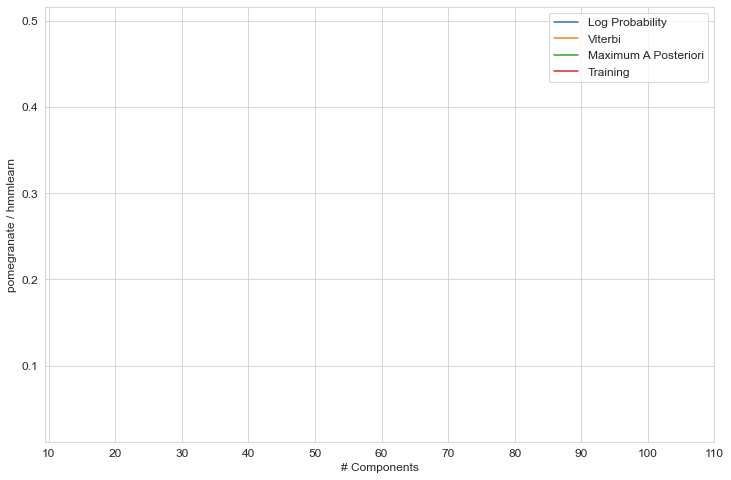

In [16]:
input_file = "Earthquakes/Chinatown_TEST_NEW_2.csv"
# generate sequence
seqs = generate_timeseries_data(input_file)
# generate basic info from sequence
n_state = 5
topology = "full"
randomize = True

# Iteration Times
ITERATION = 1
print("hidden state %s" % n_state)



print("topology %s" % topology)
print("randomize %s" % randomize)
hmmlearn_model, pomegranate_model = evaluate_models(seqs, n_state, topology, randomize, ITERATION)

# use test data
input_test_file = "Earthquakes/Chinatown_TEST_NEW_2.csv"
test_seqs = generate_timeseries_data(input_file)
hmmlearn_predict_result = hmmlearn_model.predict(test_seqs)
pomegranate_predict_result = pomegranate_model.predict(test_seqs)


In [14]:
print(test_seqs)
print(hmmlearn_predict_result)
print(pomegranate_predict_result)
plt.figure()
hmmlearn_predict_result.plot()
plt.title("hmmlearn_predict_result Data")
plt.show()

[[  71  -67]
 [  68   -3]
 [  60   -8]
 ...
 [ 961 -228]
 [ 690 -271]
 [ 328 -362]]
[1 1 1 ... 3 3 4]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

<Figure size 432x288 with 0 Axes>

In [ ]:
dists = [NormalDistribution(5, 1), NormalDistribution(1, 7), NormalDistribution(8,2)]
print(dists)

In [ ]:
d1 = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})
print(d1)

In [ ]:
d = NormalDistribution(5, 2)
d2 = ExponentialDistribution(5)
d3 = LogNormalDistribution(2, 0.4)
print(d, d2, d3)

In [15]:

x = numpy.random.normal(10, 1, size=100)

d4 = NormalDistribution.from_samples(x)
d5 = ExponentialDistribution.from_samples(x)
d6 = LogNormalDistribution.from_samples(x)
print("d4", d4)
print("d5", d5)
print("d6", d6)

[ 8.00531421  9.06074626 10.72784614 11.10348944 10.55412795 11.37806876
  9.09995056 10.01643868 10.4201854  10.53254514 11.21549599  9.31488978
  8.95151255  9.7198739   9.63921942 11.80933793  8.29931518 10.52191385
  9.59899039 10.31294196 10.50172729 10.10912383  9.9639344  11.07467695
  9.06049004 10.51445825 11.48598714 10.18456096 10.91597058 10.13404088
 11.50829341 10.88108184  8.35323188  8.89100253 10.4369899  11.0812715
  9.28580023  9.72420721  8.44490273 10.61755599 10.2860636  11.65733359
  9.80997233 11.26986167 10.32972977 11.80054536 10.37215503  9.26611668
 10.37833905 11.16629539  8.77762848  8.75137391 10.01099677 10.4235357
 10.46259417  9.72326918  8.74853351 10.89350679  9.50084835  9.42105662
 11.45141764  8.58835756 10.35538936 10.12382157  9.40054299  9.19074798
  9.46916873  9.90470164  9.76657789 10.14918504 10.83141754 11.11795192
 10.76189565 10.69998809  9.73213522 10.16793436 11.12228418 10.31815953
  7.80395758 10.72618493  9.86488551  9.5572391   9.7

In [20]:

x = numpy.random.normal(10, 1, size=(1, 3))

d7 = MultivariateGaussianDistribution.from_samples(x)
d7.mu, d7.cov
print(x)
print(d7)
print(d7.mu, d7.cov)

[[8.90840326 8.34013875 9.31161258]]
{
    "class" : "Distribution",
    "name" : "MultivariateGaussianDistribution",
    "parameters" : [
        [
            8.908403261749736,
            8.340138747244533,
            9.311612582883926
        ],
        [
            [
                1e-05,
                0.0,
                0.0
            ],
            [
                0.0,
                1e-05,
                0.0
            ],
            [
                0.0,
                0.0,
                1e-05
            ]
        ]
    ],
    "frozen" : false
}
[8.90840326 8.34013875 9.31161258] [[1.e-05 0.e+00 0.e+00]
 [0.e+00 1.e-05 0.e+00]
 [0.e+00 0.e+00 1.e-05]]


In [52]:

def initialize_components(n_components, n_dims, n_seqs):
    """
    Initialize a transition matrix for a model with a fixed number of components,
    for Gaussian emissions with a certain number of dimensions, and a data set
    with a certain number of sequences.
    """
    
    transmat = numpy.abs(numpy.random.randn(n_components, n_components))
    transmat = (transmat.T / transmat.sum( axis=1 )).T

    start_probs = numpy.abs( numpy.random.randn(n_components) )
    start_probs /= start_probs.sum()

    means = numpy.random.randn(n_components, n_dims)
    covars = numpy.ones((n_components, n_dims))
    
    seqs = numpy.zeros((n_seqs, n_components, n_dims))
    for i in range(n_seqs):
        seqs[i] = means + numpy.random.randn(n_components, n_dims)
        
    return transmat, start_probs, means, covars, seqs
initialize_components(4, 2, 10)

(array([[0.23338681, 0.27360667, 0.02534593, 0.46766059],
        [0.44932472, 0.30991248, 0.23823207, 0.00253073],
        [0.10314645, 0.23411211, 0.11218062, 0.55056082],
        [0.08057582, 0.47311348, 0.16740712, 0.27890357]]),
 array([0.37452125, 0.36991264, 0.13382348, 0.12174263]),
 array([[-0.05145295, -1.07648614],
        [-0.66223072, -1.04216088],
        [ 0.54383807, -0.74846562],
        [ 0.53894553, -1.14151853]]),
 array([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]),
 array([[[-1.57118877, -2.2783733 ],
         [-1.32938284, -2.3584233 ],
         [ 1.20656394,  0.33031774],
         [-0.18431972, -1.9539999 ]],
 
        [[ 0.79015541, -1.78315641],
         [-2.38148462, -0.51168698],
         [ 2.13860267, -3.11292722],
         [-0.19147714, -1.07993042]],
 
        [[-0.7233047 ,  1.14982583],
         [-0.82705923,  0.1698996 ],
         [ 0.09132002, -0.53827712],
         [-0.42586582, -0.51930842]],
 
        [[-0.24796424, -1.53410805]

In [ ]:
transition
array([[0.25      , 0.25      , 0.25      , 0.25      ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.        , 0.        , 0.        , 1.        ]])
start
[0.14674745 0.29236879 0.43913042 0.12175334]

In [ ]:
>>> from pomegranate import *
>>> d1 = DiscreteDistribution({'A' : 0.35, 'C' : 0.20, 'G' : 0.05, 'T' : 0.40})
>>> d2 = DiscreteDistribution({'A' : 0.25, 'C' : 0.25, 'G' : 0.25, 'T' : 0.25})
>>> d3 = DiscreteDistribution({'A' : 0.10, 'C' : 0.40, 'G' : 0.40, 'T' : 0.10})
>>>
>>> s1 = State(d1, name="s1")
>>> s2 = State(d2, name="s2")
>>> s3 = State(d3, name="s3")
>>>
>>> model = HiddenMarkovModel('example')
>>> model.add_states([s1, s2, s3])
>>> model.add_transition(model.start, s1, 0.90)
>>> model.add_transition(model.start, s2, 0.10)
>>> model.add_transition(s1, s1, 0.80)
>>> model.add_transition(s1, s2, 0.20)
>>> model.add_transition(s2, s2, 0.90)
>>> model.add_transition(s2, s3, 0.10)
>>> model.add_transition(s3, s3, 0.70)
>>> model.add_transition(s3, model.end, 0.30)
>>> model.bake()